# Part one

In [3]:
# import each library for assignment

import numpy as np
import cmath
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt import solvers

(1, 50)
(100, 50)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5527e-15  3e+02  9e-01  5e-16  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  9e-16  4e-01
 2:  5.8134e+01  5.8186e+01  1e+01  4e-02  3e-14  1e-01
 3:  6.3314e+01  6.3326e+01  2e+00  7e-03  8e-14  2e-02
 4:  6.4289e+01  6.4291e+01  4e-01  1e-03  1e-13  3e-03
 5:  6.4452e+01  6.4452e+01  7e-02  2e-04  6e-14  6e-04
 6:  6.4483e+01  6.4483e+01  3e-03  8e-06  1e-13  2e-05
 7:  6.4484e+01  6.4484e+01  3e-05  8e-08  8e-14  2e-07
Optimal solution found.
(1, 100)


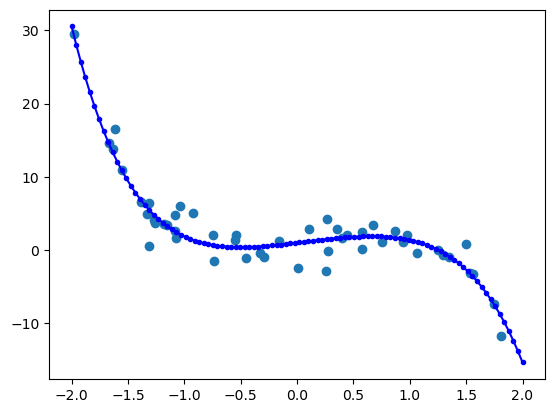

In [25]:
# load and process data

def data_processing():

    sample_X = np.loadtxt('./PA-1-data-text/polydata_data_sampx.txt')
    sample_Y = np.loadtxt('./PA-1-data-text/polydata_data_sampy.txt')
    poly_X = np.loadtxt('./PA-1-data-text/polydata_data_polyx.txt')
    poly_Y = np.loadtxt('./PA-1-data-text/polydata_data_polyy.txt')

    true_theta = np.loadtxt('./PA-1-data-text/polydata_data_thtrue.txt')

    sample_X = sample_X.reshape(1, len(sample_X))
    sample_Y = sample_Y.reshape(len(sample_Y), 1)

    poly_X = poly_X.reshape(1, len(poly_X))
    poly_Y = poly_Y.reshape(len(poly_Y), 1)

    # print(sample_X.shape)
    return sample_X, sample_Y, poly_X, poly_Y

# generate Phi(x).
def generate_Phix(X, K):
    return np.array( [ X**k for k in range(K+1)]).reshape(K+1, 1)

# generate Big Phi matrix dimen is (K, N).
def generate_Phi_mat(Sample, K):
    return np.array( [generate_Phix(x, K) for x in Sample[0]])[:,:, (Sample.shape[0]-1)].T

# Do the prediction though the fixed Theta.
def pred_polyY(polyX, Theta, K):
    Phi_mat_T = generate_Phi_mat(polyX, K).T
    pred_Y = np.dot(Phi_mat_T, Theta)
    return pred_Y

def least_squares_Theta(SampleX, SampleY, K):
    Phi_mat = generate_Phi_mat(Sample=SampleX, K=K)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T)), np.dot(Phi_mat, SampleY))
    return Theta

def Regular_LS_Theta(SampleX, SampleY, K, lbda=0.1):
    Phi_mat = generate_Phi_mat(Sample=SampleX, K=K)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T) + lbda * np.ones((K+1, K+1))), np.dot(Phi_mat, SampleY))
    return Theta

def L1_LS_Theta(SampleX, SampleY, K, lbda=1):
    # refer to the Problem Set 3.12
    # To solve Lasso, construct the matrix: 
    # X dimen:(2(K+1), 1), H dimen:(2(K+1), 2(K+1)), f dimen:(2(K+1), 1), G and h based on constraint dimen: (2(K+1), 2(K+1)), h (2(K+1) 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K)
    Phi_square = np.dot(Phi_mat, Phi_mat.T)
    Phi_y = np.dot(Phi_mat, SampleY)
    H_left = np.concatenate((Phi_square, -Phi_square), axis=0)
    H = np.concatenate( (H_left, -H_left), axis=1 )
    f = lbda*np.ones((H.shape[0], 1)) - np.concatenate( (Phi_y, -Phi_y), axis=0 )
    G = - np.identity(H.shape[0])
    h = np.zeros( (H.shape[0], 1) )
    Lasso_theta = solvers.qp(P=matrix(H), q=matrix(f), G=matrix(G), h=matrix(h))['x']
    Lasso_theta = np.matrix(Lasso_theta)
    # Lasso_theta is  [theta+, theta-]T, to get the theta = theta+ - theta-
    Theta = Lasso_theta[: int(H.shape[0]/2)] - Lasso_theta[ int(H.shape[0]/2):]
    print(H.shape, f.shape)
    return Theta
    
def Robust_LS(SampleX, SampleY, K):
     # refer to the Problem Set 2.10
    # To solve Robust, construct the matrix: 
    # X dimen:((K+1) + N, 1), f dimen:((K+1) + N, 1), , A and b based on constraint dimen:(2N, (K+1) + N), b (2N， 1) matrix
    print(SampleX.shape)
    Phi_mat = generate_Phi_mat(SampleX, K)
    f = np.concatenate((np.zeros((K+1,1)), np.ones((SampleX.shape[1],1))), axis=0)
    A_left = np.concatenate( (-Phi_mat.T, Phi_mat.T), axis=0 )
    A_right = np.concatenate( (-np.identity(SampleX.shape[1]), -np.identity(SampleX.shape[1])), axis=0)
    print(A_right.shape)
    A = np.concatenate( (A_left, A_right), axis=1 )
    b = np.concatenate((-SampleY, SampleY))
    Robust_theta = solvers.lp(G=matrix(A),c=matrix(f), h=matrix(b))['x']
    Theta = Robust_theta[: K+1]
    return Theta


x, y, b, d = data_processing()
theta = Robust_LS(x,y, 5)
pred = pred_polyY(b, theta, 5)
print(b.shape)
plt.scatter(x[0], y)
plt.plot(b[0], pred, 'b.-')
plt.show()